In [59]:
import os
import numpy as np
import healpy as hp
import pylab as plt
%matplotlib inline

import cv2

import csgan as cs

def der(data):
    lx = data.shape[0]
    ly = data.shape[1]

    datap = np.zeros((lx+1,ly+1))

    datap[:lx,:ly] = data
    datap[:lx,ly:] = data[:,:1]
    datap[lx:,:ly] = data[:1,:]
    datap[lx,ly] = data[0,0]

    dx = np.diff(datap,axis=0)
    dy = np.diff(datap,axis=1)

    strg = np.sqrt(dx[:,:ly]**2+dy[:lx,:]**2)
    mstrg = np.mean(strg)
    strg = np.where(strg>mstrg,strg,0)
    #	strg = np.where(strg<2*mstrg,1/2,0)
    ornt = np.arctan2(dx[:,:ly],dy[:lx,:])
    return [strg,ornt]

def canny(d_in,R,meth,edd):
    d = d_in
    if (R!=0):
        dt = np.fft.fft2(d)
        if meth=='g':
            for i in range(sz):
                for j in range(sz):
                    k2 = 1.*(i*i+j*j)/d.shape[0]
                    dt[i,j]=dt[i,j]*np.exp(-k2*R*R/2)

        if meth=='tp':
            for i in range(sz):
                for j in range(sz):
                    k = np.sqrt(0.001+i*i+j*j)/sz
                    dt[i,j]=dt[i,j]* 3*(np.sin(k*R)-k*R*np.cos(k*R))/(k*R)**3

        d = np.fft.ifft2(dt)
        d = abs(d)

    if edd=='lap':
        d = cv2.Laplacian(d,cv2.CV_64F)

    if edd=='sob':
        sobelx = cv2.Sobel(d,cv2.CV_64F,1,0,ksize=3)
        sobely = cv2.Sobel(d,cv2.CV_64F,0,1,ksize=3)
        d =np.sqrt(sobelx**2+sobely**2)

    if edd=='sch':
        scharrx = cv2.Scharr(d,cv2.CV_64F,1,0)
        scharry = cv2.Scharr(d,cv2.CV_64F,0,1)
        d =np.sqrt(scharrx**2+scharry**2)
        
    return d

def filt_all(maps,func):
    out1 = []
    for m in maps:
        out1.append(func(m))
        
    return np.stack([maps,np.array(out1)],axis=3)

def func(dt):
    return canny(dt,0,'none','sch')

In [60]:
dp = cs.Data_Provider('../dataset/map1n_allz_rtaapixlw_4096_1b.fits')

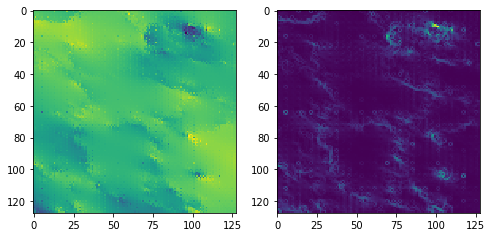

In [62]:
dt = filt_all(dp(10,128),func)
dt.shape
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,18))
ax1.imshow(dt[0,:,:,0])
ax2.imshow(dt[0,:,:,1])

In [5]:
# m = hp.read_map('../strings/map1n_allz_rtaapixlw_4096_1b'
#                  ,dtype=np.float16,verbose=0,nest=1)
# hp.mollview(m, title="Mollview image RING",nest=1)

In [78]:
ims = 256

In [79]:
import tensorflow as tf
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def discriminator(x_image, reuse=False, n_channel=2):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        #First Conv and Pool Layers
        c_dim = 2 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
        
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, c_dim, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)

        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [ims/4 * ims/4 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, ims/4*ims/4*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 2 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
        s = ims #Output size of the image
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, 
                                                                  #so these values will help
                                                                  #make that change gradual.
        dd = z_dim/s16**2
        assert dd*s16**2==z_dim,'Error!'
        h0 = tf.reshape(z, [batch_size, s16, s16, dd])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 2 x 2 x 25

        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                         strides=[1, 2, 2, 1], padding='VALID') + b_conv4
        H_conv4 = tf.nn.tanh(H_conv4)
        #Dimensions of H_conv4 = batch_size x 28 x 28 x 1

    return H_conv4

batch_size = 10
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
z_dimensions = 2*int(ims/16)**2
x_placeholder = tf.placeholder("float", shape = [None,ims,ims,2]) #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) #Placeholder for input noise vectors to the generator

Dx = discriminator(x_placeholder) #Dx will hold discriminator prediction probabilities for the real MNIST images
Gz = generator(z_placeholder, batch_size, z_dimensions) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator prediction probabilities for generated images

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg))) # ensure forward compatibility: function needs to have logits and labels args explicitly used

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print(tf.get_variable_scope().reuse)
adam = tf.train.AdamOptimizer()
trainerD = adam.minimize(d_loss, var_list=d_vars)
trainerG = adam.minimize(g_loss, var_list=g_vars)


False


In [88]:
# sess.run(tf.global_variables_initializer())
iterations = 50
for i in range(iterations):
    z_batch = np.random.normal(0, 0.25, size=[batch_size, z_dimensions])
#     real_image_batch = dp(batch_size,ims)
    real_image_batch = dt = filt_all(dp(batch_size,ims),func)

#     real_image_batch = np.reshape(real_image_batch,[batch_size,ims,ims,2])
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator 
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch}) #Update the discriminator
    if i%50==0:
        print dLoss,gLoss

0.280355 1.42385


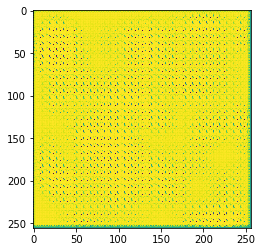

In [87]:
sample_image = generator(z_placeholder, 1, z_dimensions,reuse=1)
z_batch = np.random.normal(0, 0.25, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i[:,:,0])

In [90]:
# 			self.saver.restore(self.sess, model_add+'/model')
# 		else:
# 			init = tf.global_variables_initializer()
# 			self.sess.run(init)

# 	def restore(self):
# 		tf.reset_default_graph()
# 		self.saver.restore(self.sess, self.model_add+'/model')

def ch_mkdir(directory):
    """
    ch_mkdir : This function creates a directory if it does not exist.

    Arguments:
        directory (string): Path to the directory.

    --------
    Returns:
        null.		
    """
    if not os.path.exists(directory):
          os.makedirs(directory)
saver = tf.train.Saver()
ch_mkdir('model')
saver.save(sess, 'model/model')

'model/model'